<a href="https://colab.research.google.com/github/Romneasek/DT_and_Ensemble_project/blob/main/DT_and_Ensemble_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [528]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import zscore

In [529]:
data = pd.read_csv('/content/talking_data.csv')

In [530]:
data.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [531]:
data.shape

(100000, 8)

In [532]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ip               100000 non-null  int64 
 1   app              100000 non-null  int64 
 2   device           100000 non-null  int64 
 3   os               100000 non-null  int64 
 4   channel          100000 non-null  int64 
 5   click_time       100000 non-null  object
 6   attributed_time  227 non-null     object
 7   is_attributed    100000 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 6.1+ MB


In [533]:
data.describe()

,ip,app,device,os,channel,is_attributed
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,91255.879670,12.04788,21.771250,22.818280,268.832460,0.002270
std,69835.553661,14.94150,259.667767,55.943136,129.724248,0.047591
min,9.000000,1.00000,0.000000,0.000000,3.000000,0.000000
25%,40552.000000,3.00000,1.000000,13.000000,145.000000,0.000000
50%,79827.000000,12.00000,1.000000,18.000000,258.000000,0.000000
75%,118252.000000,15.00000,1.000000,19.000000,379.000000,0.000000
max,364757.000000,551.00000,3867.000000,866.000000,498.000000,1.000000


In [534]:
# Find missing value like null, unknown, and other
data.isnull().sum()

ip                     0
app                    0
device                 0
os                     0
channel                0
click_time             0
attributed_time    99773
is_attributed          0
dtype: int64

In [535]:
# Let drop the column 'attributed_time' since it has amost all NaN Value
data.drop(['attributed_time'], axis=1, inplace=True)

In [536]:
data.head()

,ip,app,device,os,channel,click_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,0
1,105560,25,1,17,259,2017-11-07 13:40:27,0
2,101424,12,1,19,212,2017-11-07 18:05:24,0
3,94584,13,1,13,477,2017-11-07 04:58:08,0
4,68413,12,1,1,178,2017-11-09 09:00:09,0


In [537]:
data.dtypes

ip                int64
app               int64
device            int64
os                int64
channel           int64
click_time       object
is_attributed     int64
dtype: object

In [538]:
# Number of unique values in each column
def fraction_unique(x):
    return len(data[x].unique())

number_unique_vals = {x: fraction_unique(x) for x in data.columns}
number_unique_vals

{'app': 161,
 'channel': 161,
 'click_time': 80350,
 'device': 100,
 'ip': 34857,
 'is_attributed': 2,
 'os': 130}

In [539]:
# plot the average of 'is_attributed', or 'download rate'
# with app (clearly this is non-readable)
app_target = data.groupby('app').is_attributed.agg(['mean', 'count'])
app_target

,mean,count
app,,
1,0.000000,3135
2,0.000000,11737
3,0.000219,18279
4,0.000000,58
5,0.074468,188
...,...,...
486,0.000000,1
536,0.000000,1
538,0.000000,1


In [540]:
# This is clearly non-readable, 
# so let's first get rid of all the apps that are very rare 
# (say which comprise of less than 20% clicks) and plot the rest.

frequent_apps = data.groupby('app').size().reset_index(name='count')
frequent_apps = frequent_apps[frequent_apps['count']>frequent_apps['count'].quantile(0.80)]
frequent_apps = frequent_apps.merge(data, on='app', how='inner')
frequent_apps.head()

,app,count,ip,device,os,channel,click_time,is_attributed
0,1,3135,17059,1,17,135,2017-11-09 01:17:58,0
1,1,3135,52432,1,13,115,2017-11-07 17:22:52,0
2,1,3135,89242,1,27,124,2017-11-07 09:37:21,0
3,1,3135,123994,1,19,101,2017-11-09 14:27:57,0
4,1,3135,34067,1,15,134,2017-11-07 15:06:06,0


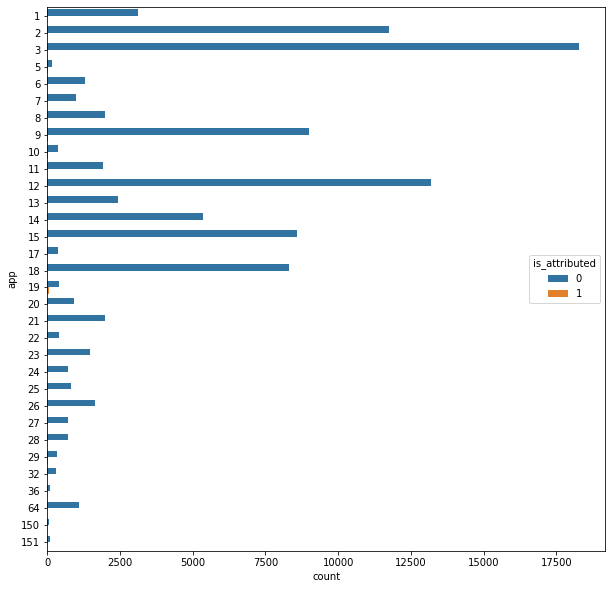

In [541]:
plt.figure(figsize=(10,10))
sns.countplot(y="app", hue="is_attributed", data=frequent_apps);

In [542]:
# Let's now derive some new features from the existing ones. 
# There are a number of features one can extract from click_time itself, 
# by grouping combinations of IP with other features.

# Creating datetime variables
# takes in a df, adds date/time based columns to it, and returns the modified df
def timeFeatures(df):
    # Derive new features using the click_time column
    df['datetime'] = pd.to_datetime(df['click_time'])
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df["day_of_year"] = df["datetime"].dt.dayofyear
    df["month"] = df["datetime"].dt.month
    df["hour"] = df["datetime"].dt.hour
    return df

In [543]:
# creating new datetime variables and dropping the old ones
new_data = timeFeatures(data)
new_data.drop(['click_time', 'datetime'], axis=1, inplace=True)
new_data.head()

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour
0,87540,12,1,13,497,0,1,311,11,9
1,105560,25,1,17,259,0,1,311,11,13
2,101424,12,1,19,212,0,1,311,11,18
3,94584,13,1,13,477,0,1,311,11,4
4,68413,12,1,1,178,0,3,313,11,9


In [544]:
new_data.shape

(100000, 10)

In [545]:
new_data.dtypes

ip               int64
app              int64
device           int64
os               int64
channel          int64
is_attributed    int64
day_of_week      int64
day_of_year      int64
month            int64
hour             int64
dtype: object

In [546]:
print(new_data.isnull().sum())
print(new_data.info())
print(new_data.describe())

ip               0
app              0
device           0
os               0
channel          0
is_attributed    0
day_of_week      0
day_of_year      0
month            0
hour             0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   ip             100000 non-null  int64
 1   app            100000 non-null  int64
 2   device         100000 non-null  int64
 3   os             100000 non-null  int64
 4   channel        100000 non-null  int64
 5   is_attributed  100000 non-null  int64
 6   day_of_week    100000 non-null  int64
 7   day_of_year    100000 non-null  int64
 8   month          100000 non-null  int64
 9   hour           100000 non-null  int64
dtypes: int64(10)
memory usage: 7.6 MB
None
                  ip           app         device             os  \
count  100000.000000  100000.00000  100000.000000  100000.0

In [547]:
# garbage collect (unused) object
import gc
gc.collect()

8489

In [548]:
# Modeling
# Splitting Dataset into 80:20 ratio
from sklearn.model_selection import train_test_split

X = new_data.drop(['is_attributed'], axis=1)
y = new_data['is_attributed']

train_X, test_X,  train_y, test_y = train_test_split(X,y, test_size = 0.20, random_state = 100)

print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(80000, 9)
(20000, 9)
(80000,)
(20000,)


In [549]:
# check the average download rates in train and test data, should be comparable
print(train_y.mean())
print(test_y.mean())

0.002275
0.00225


In [550]:
# Training the model
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

model = XGBClassifier()
model.fit(train_X, train_y)

XGBClassifier()

In [551]:
# make first 10 predictions for test data
# use predict_proba since we need probabilities to compute auc
y_pred = model.predict_proba(test_X)
y_pred[:10]

array([[9.9986595e-01, 1.3403961e-04],
       [9.9958819e-01, 4.1180410e-04],
       [9.9976069e-01, 2.3931921e-04],
       [9.9964881e-01, 3.5120550e-04],
       [9.9844450e-01, 1.5554893e-03],
       [9.9970138e-01, 2.9860999e-04],
       [9.9964988e-01, 3.5013689e-04],
       [9.9954039e-01, 4.5962850e-04],
       [9.9980426e-01, 1.9574487e-04],
       [9.9957287e-01, 4.2712971e-04]], dtype=float32)

In [552]:
# evaluate predictions
from sklearn import metrics
roc = metrics.roc_auc_score(test_y, y_pred[:, 1])
print("AUC: %.2f%%" % (roc * 100.0))

AUC: 99.63%


In [553]:
from sklearn.ensemble import BaggingClassifier

bgcl = BaggingClassifier(n_estimators=10, max_samples= .7, bootstrap=True)
bgcl = bgcl.fit(train_X, train_y)

test_pred = bgcl.predict(test_X)
bgcl_score=bgcl.score(test_X, test_y)
print("The Bagging classifier model accuracy is {}%".format(bgcl_score*100,2))
print("The confusion matrix of Bagging classifier model is")
print(metrics.confusion_matrix(test_y,test_pred))

The Bagging classifier model accuracy is 99.81%
The confusion matrix of Bagging classifier model is
[[19950     5]
 [   33    12]]


In [554]:
# feature importance
importance = dict(zip(train_X.columns, model.feature_importances_))
importance

{'app': 0.27591798,
 'channel': 0.24396735,
 'day_of_week': 0.033094905,
 'day_of_year': 0.0,
 'device': 0.18713447,
 'hour': 0.060223915,
 'ip': 0.12263195,
 'month': 0.0,
 'os': 0.07702942}

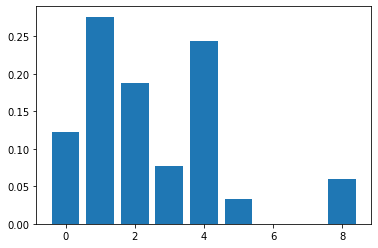

In [555]:
# plot
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

In [ ]:
# The accuracy for BaggingClassifier is 99.81%
# The accuracy for XGBoostClassifier is 99.63%